<a href="https://colab.research.google.com/github/mesahwi/Birdsong_Continuity/blob/main/Naive_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/2.Projects/Motor Neural Dynamics Project/Continuity/codes/utils')

In [2]:
from misc import *
from globals import *
import compute_continuity

import numpy as np
import pandas as pd

import scipy.io

loading syllable path pairs...


In [3]:
# Loading data
audioevt_onset = np.load(DATADIR+'audioevt_onset.npy')
audioevt_duration = np.load(DATADIR+'audioevt_duration.npy')
audioevt_isdir = np.load(DATADIR+'audioevt_isdir.npy')
audioevt_group = np.load(DATADIR+'audioevt_group.npy')
audioevt_fsource = np.load(DATADIR+'audioevt_fsource.npy')

spk_cluster = np.load(DATADIR+'spk_cluster.npy')
spk_fsource = np.load(DATADIR+'spk_fsource.npy')
spk_times = np.load(DATADIR+'spk_times.npy')

audioevt_group_info = pd.read_csv(DATADIR+'audioevt_group_info.tsv', delimiter='\t', header=0)
file_info = pd.read_csv(DATADIR+'file_info.tsv', delimiter='\t', header=0)
spk_cluster_info = pd.read_csv(DATADIR+'spk_cluster_info.tsv', delimiter='\t', header=0)

vocal_data = scipy.io.loadmat(DATADIR+'vocal_data_g4r4_20190718_02.mat')
spec_files = vocal_data['specs'][0]

In [4]:
## Audio Data (Start and Duration)
audioevt_properties = pd.DataFrame()

aud_idx1 = np.isin(audioevt_group, [2]) #syllable A
aud_idx2 = np.isin(audioevt_fsource, [1]) #first file
# aud_idx = np.logical_and(aud_idx1, aud_idx2)
aud_idx = aud_idx1

audioevt_properties['evt_id'] = np.arange(len(audioevt_onset[aud_idx]))
audioevt_properties['syllable_start'] = audioevt_onset[aud_idx]
audioevt_properties['duration'] = audioevt_duration[aud_idx]
audioevt_properties['file_num'] = audioevt_fsource[audioevt_group==2]

In [5]:
##Getting rid of faulty syllables : 213, 312, 431
audioevt_properties.drop(index=[213,312,431], inplace=True)
audioevt_properties['evt_id'] = np.arange(audioevt_properties.shape[0])
audioevt_properties.reset_index(drop=True, inplace=True)
audioevt_properties

,evt_id,syllable_start,duration,file_num
0,0,2347741,7775,1
1,1,2356481,7637,1
2,2,2365884,7613,1
3,3,2378125,7557,1
4,4,2488812,7530,1
...,...,...,...,...
573,573,875109,7588,11
574,574,884463,7602,11
575,575,896732,7452,11
576,576,909070,7501,11


In [6]:
neural2spectral_delay = ms2samples(30,20)
neural_bin_size = ms2samples(30, 20)

In [7]:
spectral_full_window = [ms2samples(0,20), ms2samples(420,20)]
neural_full_window = [ms2samples(0,20)-neural2spectral_delay, ms2samples(420,20)-neural2spectral_delay]

### Spectrogram

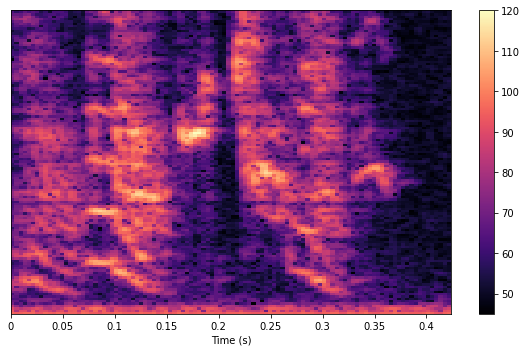

In [8]:
spectral_full_activity = get_spectral_activity(spec_files, audioevt_properties, spectral_full_window)
plot_spectrogram(spectral_full_activity, title=None)

## neural

In [8]:
total_channels = spk_cluster_info['id'].unique()
channels_of_interest = total_channels[(total_channels >= 220) & (total_channels <= 300)] #LMAN

In [9]:
neural_properties_list = get_neural_properties_list(audioevt_fsource, spk_fsource, spk_cluster_info, spk_times, spk_cluster)

In [11]:
neural_properties_list[0] ## for first file

,channel_id,file_num,spikes
0,0,1,[]
1,1,1,[]
2,2,1,[]
3,3,1,"[300, 585, 717, 857, 1085, 1219, 1440, 1566, 1..."
4,4,1,[]
...,...,...,...
261,304,1,"[10454, 11955, 36231, 36389, 36997, 39481, 397..."
262,305,1,"[5080, 9415, 10327, 10335, 10849, 11003, 13077..."
263,306,1,"[435, 1096, 2462, 2962, 3835, 5657, 8189, 8596..."
264,307,1,"[521439, 1168810, 2437865, 3048073, 3048215, 3..."


## Raster

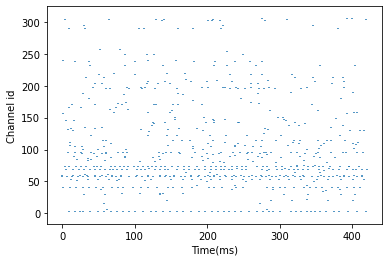

In [12]:
plot_raster(audioevt_onset, neural_properties_list, 0, 0, neural_full_window, channels_of_interest=neural_properties_list[0]['channel_id'])

# compute continuity

In [ ]:
o = compute_continuity.continuity_computation(neural_properties_list, spec_files, audioevt_properties, 
                                              channels_of_interest, neural_full_window, spectral_full_window, 
                                              syllable_path_pairs=compute_continuity.syllable_path_pairs)

In [ ]:
o.to_csv(OUTPUTDIR+'20210512/naive_knn.csv')

In [ ]:
o

,evt_id,syllable_start,duration,file_num,NNN_id,NNN_dist,NNN_avg,NSN_id,NSN_dist,NSN_avg,CSS_dist,CSS_avg,CNS_dist,CNS_avg,CSS_Rmins,RSS_Ravgs,CNS_Rmins,RNS_Ravgs
0,0,2347741,7775,1,"[355, 490, 528, 378, 503, 33, 507, 47, 214, 440]","[6.556317414491358, 6.566594930655184, 8.21557...",8.624476,"[367, 4, 230, 85, 92, 217, 13, 84, 215, 15]","[78.98785356553152, 79.7492777126071, 79.77892...",80.007885,"[91.45137525502845, 103.49351581093535, 87.787...",92.450685,"[28.978981520665805, 13.055037462139339, 15.55...",31.997198,1.155520,1.144978,3.710045,3.759746
1,1,2356481,7637,1,"[416, 198, 199, 157, 237, 335, 250, 49, 339, 42]","[5.375316990701615, 7.193411162641926, 7.34344...",8.281985,"[14, 6, 30, 147, 18, 5, 155, 3, 50, 214]","[74.56800857621246, 76.78669793155676, 77.5869...",77.964762,"[98.48956251716889, 88.11439217298286, 84.1694...",87.441600,"[35.028859766943775, 31.629014486839424, 41.48...",25.574125,1.121553,1.144429,3.087922,3.666616
2,2,2365884,7613,1,"[30, 452, 533, 181, 534, 320, 275, 332, 440, 381]","[6.013492141939303, 7.1181507571603335, 7.1598...",8.261903,"[1, 3, 6, 449, 232, 214, 14, 205, 30, 73]","[79.26729417948155, 79.46815225613958, 79.5354...",80.005780,"[80.50423339775928, 81.68814110724142, 95.6857...",90.602529,"[41.064422587091975, 16.483809088833066, 13.19...",20.266457,1.132450,1.154843,2.453001,4.273015
3,3,2378125,7557,1,"[505, 146, 230, 235, 207, 401, 509, 366, 507, ...","[5.374712643678165, 7.331034482758627, 7.34770...",7.999749,"[6, 14, 18, 1, 161, 159, 2, 48, 13, 216]","[76.69686174008213, 76.96691358442996, 77.6529...",78.790386,"[90.43418276785988, 88.76267553749265, 82.2123...",87.704076,"[11.827586206896552, 24.031140258091817, 29.99...",24.133240,1.113132,1.146179,3.016749,3.577530
4,4,2488812,7530,1,"[528, 469, 337, 558, 275, 72, 362, 401, 507, 505]","[8.065229722064661, 8.43149210903874, 9.070229...",9.564305,"[14, 18, 92, 235, 94, 230, 354, 356, 43, 231]","[74.89351229215498, 75.25025571901762, 75.5387...",76.501136,"[90.17754678917177, 86.51510828162117, 79.4951...",85.681236,"[24.697553493939836, 36.92666880616176, 34.732...",28.739211,1.120000,1.159074,3.004840,3.298377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,573,875109,7588,11,"[572, 575, 510, 544, 330, 481, 373, 123, 413, ...","[11.710900243309005, 11.79569321533924, 11.796...",13.065159,"[574, 576, 575, 577, 572, 145, 138, 142, 3, 1]","[67.59392340896936, 72.10251406081017, 73.6489...",78.154693,"[81.18198445594184, 73.64895873632, 90.2947682...",89.208397,"[29.917715617715633, 38.87511811023624, 11.795...",33.796861,1.141434,1.188484,2.586793,3.630491
574,574,884463,7602,11,"[139, 137, 132, 112, 115, 427, 346, 146, 379, ...","[9.70659556271066, 9.938669438669425, 10.46453...",11.302794,"[573, 575, 576, 577, 1, 6, 3, 193, 572, 145]","[67.59392340896936, 67.93625374892684, 69.8676...",78.593152,"[88.86119493121184, 101.73067747656503, 87.765...",93.017335,"[29.917715617715633, 32.98917012191349, 17.387...",23.660730,1.183530,1.209447,2.093352,2.724228
575,575,896732,7452,11,"[573, 123, 510, 481, 572, 373, 92, 383, 330, 332]","[11.79569321533924, 12.824882873503382, 15.521...",15.888193,"[576, 577, 574, 573, 7, 145, 193, 142, 21, 135]","[64.44443100047101, 65.83409636350586, 67.9362...",78.070022,"[73.64895873632, 96.47341900885496, 90.7795857...",90.812835,"[40.99965159222355, 21.362983132894648, 32.989...",40.612304,1.163223,1.209544,2.556131,3.175902
576,576,909070,7501,11,"[144, 537, 495, 139, 321, 126, 472, 138, 97, 163]","[8.461281743755531, 10.31319299373292, 11.1693...",11.952951,"[575, 577, 574, 573, 7, 21, 142, 193, 1, 549]","[64.44443100047101, 64.96518938731631, 69.8676...",77.782238,"[87.67764566436148, 90.8241258086328, 109.8730...",95.414671,"[40.99965159222355, 23.358907059694477, 17.387...",28.832768,1.226690,1.213984,2.412188,2.684756
